![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
# Loan Approval Model: Reducing Financial Losses in Automated Loan Decisions

## Overview

We developed a machine learning model to predict **LoanApproved** status for applicants, automating part of the loan screening process. The goal is to standardize approvals, reduce manual inconsistencies, and shorten decision times.  

Because the historical approvals in the dataset reflect **loan officer decisions**, the model cannot outperform officers when judged strictly against those same labels. Instead, our contribution is twofold:  
1. Demonstrating that machine learning can replicate approval outcomes with consistency and speed.  
2. Embedding a **business-cost–aware evaluation framework** that, if repayment/default outcomes were available, would directly tie model decisions to financial impact.  

Our best-performing model, a **Logistic Regression (C=10, threshold tuned to 0.88)**, achieved a **Misclassification Cost per Loan** of approximately **$535.60** when evaluated against officer labels, compared with a naïve deny-all baseline of **$1,912**. This represents an improvement of roughly **$1,376 per loan** (a **72% reduction**). While this does not imply cost savings over historical practice, it shows that cost-sensitive modeling can guide approval policies if applied directly to repayment outcomes in future data.



## Business Understanding

### Current Process & Limitations
FinTech Innovations currently relies on manual loan officer reviews. While officers are experienced, they may apply inconsistent criteria, leading to delayed decisions, overlooked creditworthy applicants, or approved risky loans. This results in both lost profits (from denying good applicants) and significant financial losses (from approving bad ones).

---

### Stakeholders
- **Loan Officers**: Want a reliable, assistive model that reduces workload and flags applicants consistently.  
- **Risk & Compliance Teams**: Require interpretability and auditability to satisfy regulatory standards.  
- **Executive Leadership**: Focused on minimizing losses while maximizing profitable loans.  
- **Customers**: Expect fair, fast, and unbiased loan decisions.

---

### Implications of Model Errors
- **False Positive (FP: approving a bad loan)** → ~$50,000 average loss (principal + collection).  
- **False Negative (FN: denying a good loan)** → ~$8,000 lost profit opportunity.  

Since FPs are ~6× more costly than FNs, the model was tuned to prioritize minimizing false approvals even at the expense of occasionally denying good applicants.

---

### Modeling Approach

We framed this as a **classification task** using **LoanApproved** as the target variable. The `RiskScore` field was excluded because it is a derived outcome that could introduce data leakage.  

To balance interpretability, probability calibration, and non-linear flexibility, we evaluated three complementary models:

- **Logistic Regression** – Simple and interpretable, with well-calibrated probability outputs that make it especially effective for threshold tuning in cost-sensitive settings.  
- **Support Vector Machine (linear kernel)** – A strong linear benchmark capable of capturing subtle separation boundaries.  
- **Random Forest** – A non-linear ensemble able to model complex feature interactions, providing contrast to the linear models.  

We applied cross-validation with a custom **cost-based metric** to compare models, then tuned the decision threshold on a validation split to minimize expected dollar losses.  

---

### Evaluation Metrics
To align with business impact, we evaluated models using:  

1. **Accuracy** – General performance overview.  
2. **Recall** – Ensures we identify as many good applicants as possible (limiting lost profit).  
3. **Precision** – Ensures approved applicants are indeed good (limiting bad loan losses).  
4. **ROC-AUC** – Summarizes classification performance across thresholds.  
5. **Custom Business Metric: Misclassification Cost per Loan ($)**  
   - Defined as:  
     ```
     Misclassification Cost = (FN_rate × $8,000) + (FP_rate × $50,000)
     ```
   - Reported in **dollars per loan** (lower is better).  
   - Implemented as a negated scorer for optimization (higher = less costly).  

This custom metric directly translates model outcomes into **dollars lost per decision**, making it intuitive for executives and aligned with company priorities.

---

### Success Criteria

- **Baseline:** A naïve deny-all (majority-class) policy produces an average cost of ≈ $1,912 per loan under our cost framework. This serves as a **benchmark**, not a reflection of real financial performance.  
- **Target:** Show that a machine learning model can reduce average misclassification cost vs. this naïve baseline, demonstrating the feasibility of cost-sensitive optimization.  
- **Result:** The Logistic Regression model reduced average cost/loan to ≈ $535.60, a ~72% relative reduction.
- **Interpretability & Compliance:** Models were evaluated for feature importance and segment-level fairness. These analyses provide transparency and set the stage for regulatory review.  
- **Business Value:** While trained on historical officer approvals, this framework can be extended to repayment/default outcomes. In that context, the model would directly minimize **dollar losses** from defaults and missed profits, delivering measurable cost efficiency in future deployments.


> **Cost assumptions used throughout**: We model a false positive (approving a loan that defaults) as a $50,000 loss and a false negative (denying a creditworthy loan) as an $8,000 missed profit. These values come from the business brief; if your institution’s book differs, change `COST_FP` / `COST_FN` at the top of the modeling section and re-run to propagate.


## Data Understanding

The dataset consists of ~20,000 historical loan applications with 35 features covering demographic information, financial indicators, and loan performance outcomes. Two potential targets were available: **LoanApproved** (binary classification) and **RiskScore** (continuous regression).  

Because `LoanApproved` reflects **human loan officer decisions**, not actual repayment outcomes, our analysis cannot claim to outperform officers financially. Instead, the model is evaluated on its ability to **replicate approval patterns consistently** while using a **cost-aware evaluation framework** that could be extended to repayment outcomes in future data.  

---

### Distributions of Features and Target Variables
- **LoanApproved** is moderately imbalanced, with more denials than approvals. This imbalance must be considered when selecting metrics and thresholds.  
- Key numeric features such as **AnnualIncome, LoanAmount, NetWorth, and Debt-to-Income Ratio** show wide spreads and meaningful differences between approved and denied applicants.  
- Categorical features like **EmploymentStatus, EducationLevel, and HomeOwnershipStatus** vary in approval rates, suggesting predictive value.  

---

### Relationships Between Features
- **Loan-to-Income Ratio, Payment-to-Income Ratio, and NetWorth-to-Loan Ratio** (engineered features) are strongly associated with approval outcomes.  
- **Higher income and net worth** tend to align with approvals, while **higher loan burden and debt ratios** align with denials.  
- Correlations among financial indicators (e.g., income with net worth, loan amount with monthly payment) behave as expected.

---

### Data Quality Issues
- Several financial fields (e.g., **AnnualIncome, LoanAmount**) were stored as strings with symbols, requiring cleaning.  
- Missing values existed across both numeric and categorical features. We addressed these with **median imputation for numerics** and **most-frequent imputation for categoricals**.  
- Outliers are present in features like **Income and NetWorth**, but we retained them after scaling, letting tree-based models and engineered ratios absorb their impact.

---

### Feature Understanding

#### Feature Types
- **Numerical**: Age, CreditScore, AnnualIncome, LoanAmount, Debt-to-Income Ratio, NetWorth, etc.  
- **Categorical**: EmploymentStatus, EducationLevel, MaritalStatus, HomeOwnershipStatus, LoanPurpose, BankruptcyHistory.  
- **Engineered**: Loan-to-Income, Payment-to-Income, NetWorth-to-Loan.  

#### Preprocessing Steps
- Numeric features: median imputation + StandardScaler.  
- Categorical features: most-frequent imputation + one-hot encoding.  
- Ratios engineered to highlight ability-to-pay signals.  

#### Future Opportunities
- Bin **CreditScore** into ranges (poor, fair, good, excellent) for interpretability.  
- Winsorize or log-transform extreme values in **Income, LoanAmount, NetWorth**.  
- Consolidate rare categories in features like **LoanPurpose** to avoid sparse dummies.  

---

### Takeaway
Financial health indicators such as **Debt-to-Income, Loan-to-Income, Payment-to-Income, and NetWorth-to-Loan** are central to distinguishing between applicants who were historically approved vs. denied.  

It is important to note that **approval ≠ repayment performance**. Because our target reflects past officer decisions, the model cannot demonstrate true financial superiority over humans in this dataset. However, our exploration of cost-sensitive evaluation provides a framework that could be directly applied to repayment/default outcomes in future data, enabling measurable business impact.

In [ ]:
# ============================================
# Imports
# ============================================

# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Modeling & Preprocessing
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics & Evaluation
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, precision_recall_curve,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, auc, make_scorer
)



=== Preview of Raw Data ===


,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,45,"$39,948.00",617,Employed,Master,22,13152,48,Married,2,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,38,"$39,709.00",628,Employed,Associate,15,26045,48,Single,1,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,47,"$40,724.00",570,Employed,Bachelor,26,17627,36,NaN,2,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,58,"$69,084.00",545,Employed,High School,34,37898,96,Single,1,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,37,"$103,264.00",594,Employed,Associate,17,9184,36,Married,1,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0



=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  object 
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              19099 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               18669 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberO

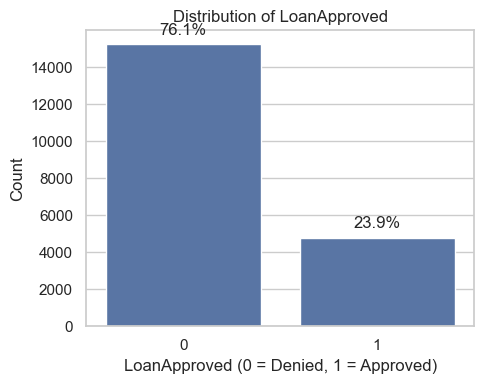

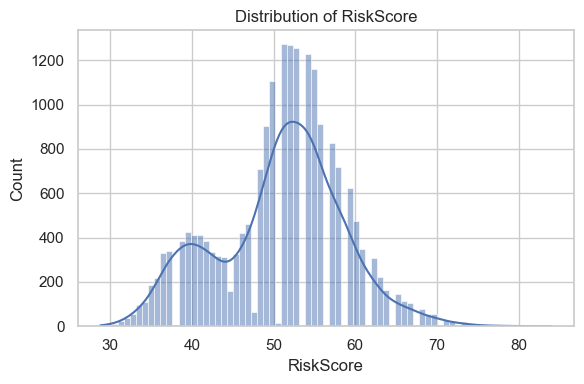

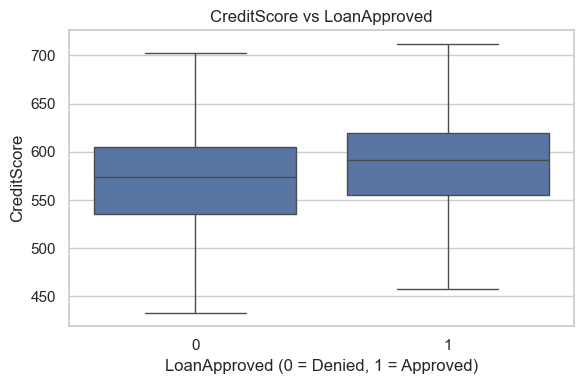

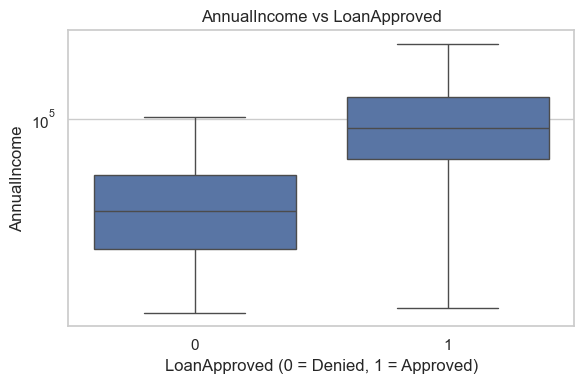

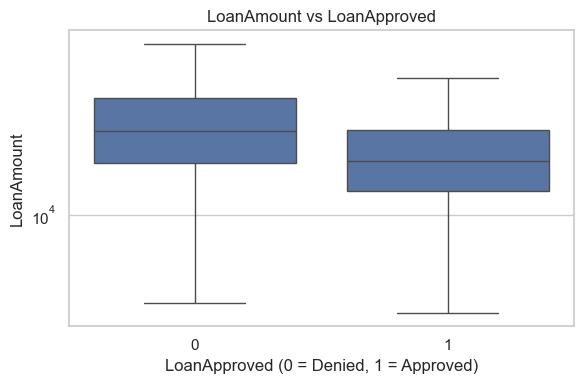

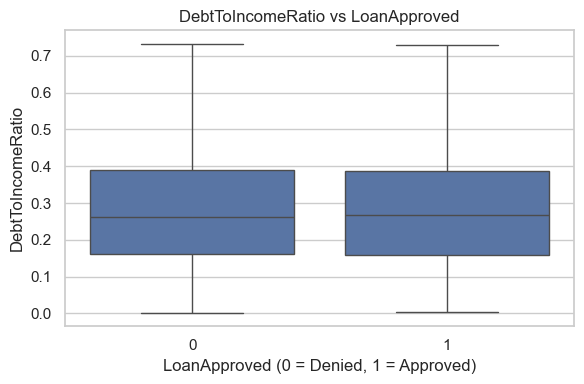

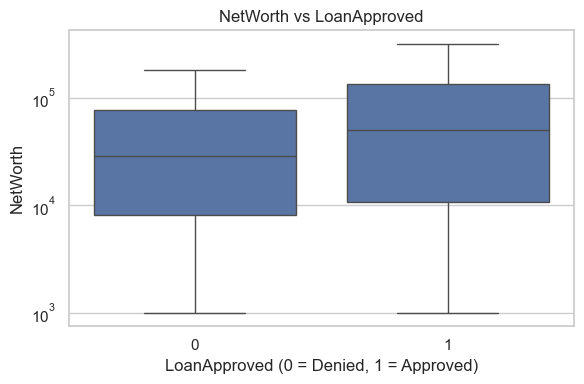

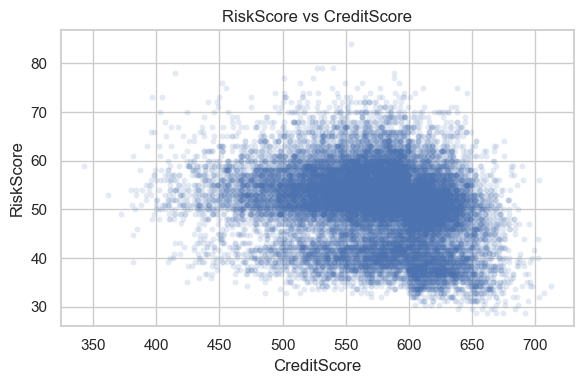

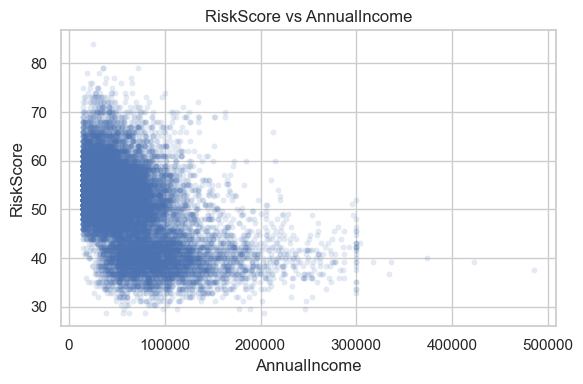

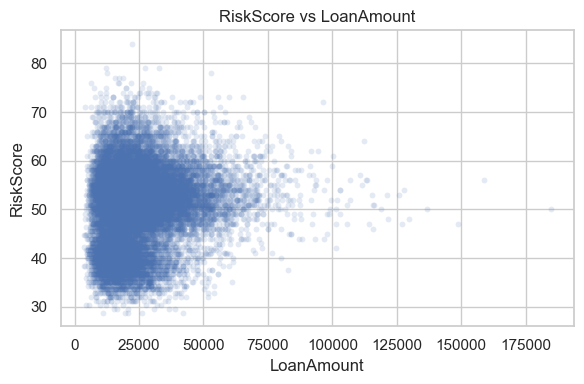

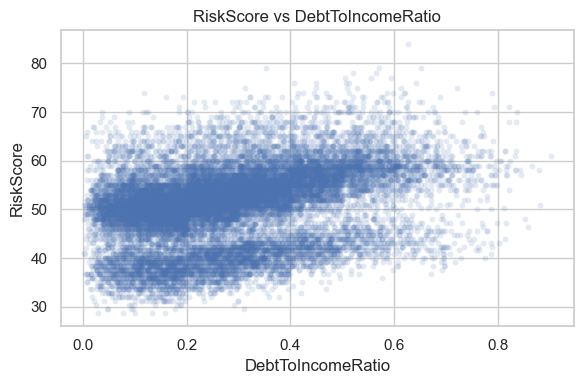

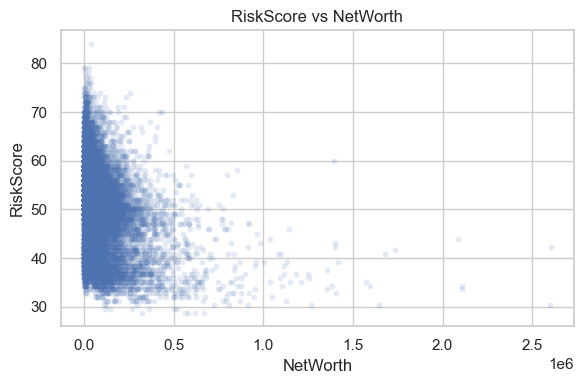

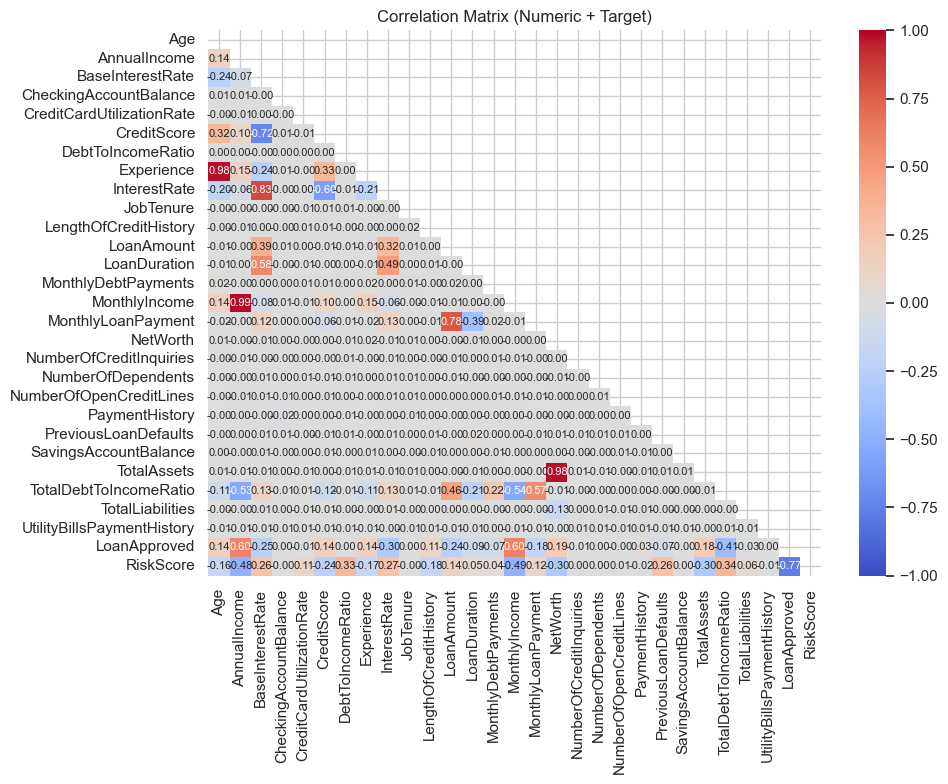

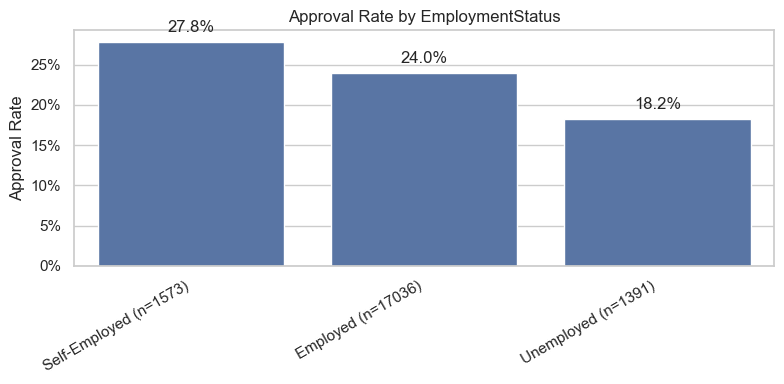

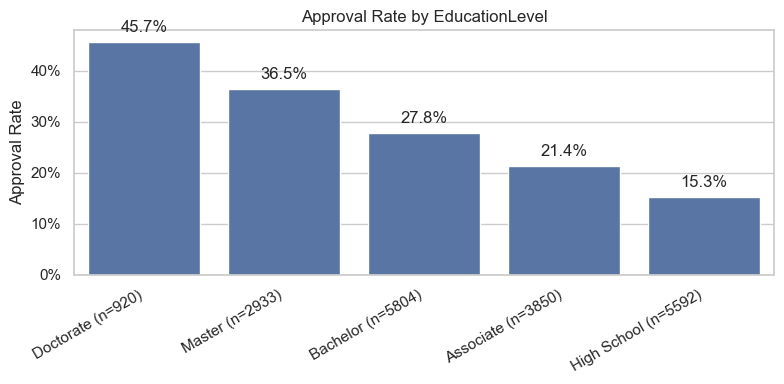

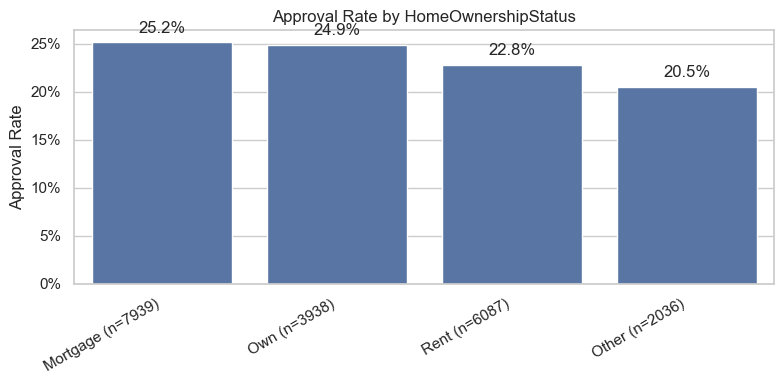

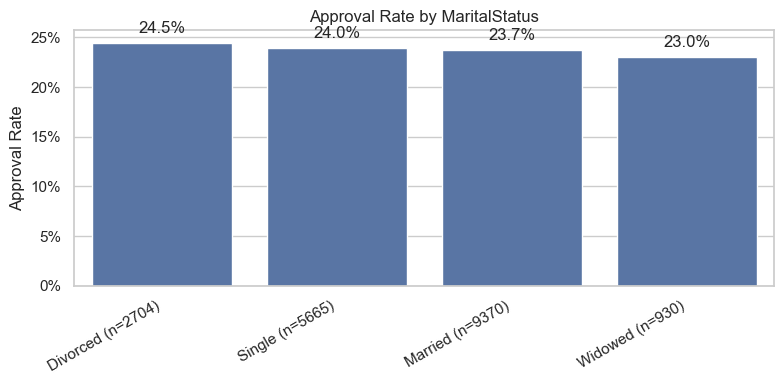

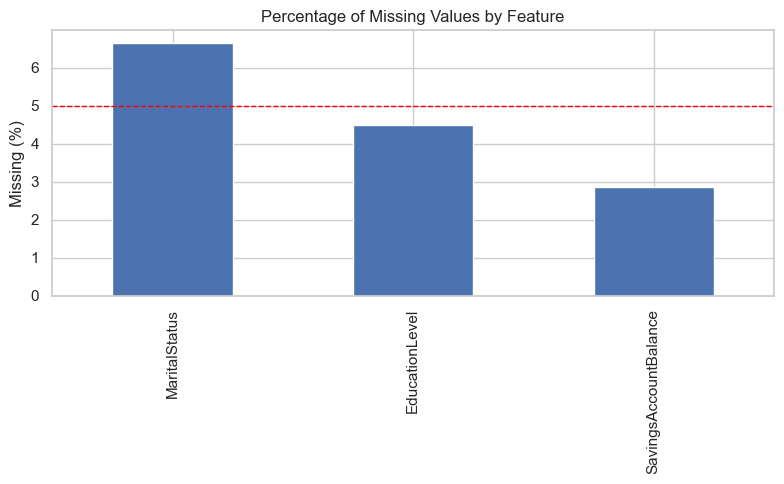

In [ ]:
# ============================================
# ESSENTIAL EDA
# ============================================

sns.set(style="whitegrid", palette="deep")

# --- Load & basic clean ---
CSV_PATH = "financial_loan_data.csv"  # adjust if needed
data_eda = pd.read_csv(CSV_PATH)

# Quick look at structure and missingness
print("\n=== Preview of Raw Data ===")
display(data_eda.head())

print("\n=== DataFrame Info ===")
data_eda.info()

print("\n=== Missing Values (raw) ===")
print(data_eda.isnull().sum())

# Clean AnnualIncome (common issue in provided CSVs)
if "AnnualIncome" in data_eda.columns and data_eda["AnnualIncome"].dtype == "object":
    data_eda["AnnualIncome"] = (
        data_eda["AnnualIncome"]
        .replace(r"[\$,]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

# Targets (optional presence)
CLASS_TARGET = "LoanApproved" if "LoanApproved" in data_eda.columns else None
REGR_TARGET  = "RiskScore"    if "RiskScore"    in data_eda.columns else None
targets = [t for t in [CLASS_TARGET, REGR_TARGET] if t is not None]

# Feature splits
categorical_features = (
    data_eda.select_dtypes(include=["object", "category"]).columns.difference(targets).tolist()
)
numeric_features = (
    data_eda.select_dtypes(include=["number", "bool"]).columns.difference(targets).tolist()
)

print()
print(f"Rows: {len(data_eda)}")
print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

# Optional: which numerics to consider for “key” plots (auto-filter if missing)
key_numeric = [c for c in ["CreditScore","AnnualIncome","LoanAmount",
                           "DebtToIncomeRatio","NetWorth"] if c in numeric_features]

# Some very wide features benefit from log y-scale in boxplots
LOG_Y_FEATURES = {"AnnualIncome", "LoanAmount", "NetWorth"}

# -----------------------------
# Helpers
# -----------------------------
def annotate_bars_as_percent(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.1%}",
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom', xytext=(0, 5),
                    textcoords='offset points')

def annotate_bars_as_value(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.2f}",
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom', xytext=(0, 5),
                    textcoords='offset points')

def add_counts_to_index(idx, series_for_counts):
    """Return labels like 'Category (n=123)' preserving order."""
    counts = series_for_counts.value_counts(dropna=False)
    label_map = {k: f"{k} (n={counts.get(k, 0)})" for k in idx}
    return [label_map[k] for k in idx]

# ==================================================
# 1) Target Distribution (with % labels)
# ==================================================
if CLASS_TARGET:
    plt.figure(figsize=(5, 4))
    ax = sns.countplot(x=data_eda[CLASS_TARGET])
    total = len(data_eda)
    for p in ax.patches:
        pct = p.get_height() / total if total else 0
        ax.annotate(f"{pct:.1%}",
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5),
                    textcoords='offset points')
    ax.set_title("Distribution of LoanApproved")
    ax.set_xlabel("LoanApproved (0 = Denied, 1 = Approved)")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

if REGR_TARGET:
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(data_eda[REGR_TARGET], kde=True)
    ax.set_title("Distribution of RiskScore")
    ax.set_xlabel("RiskScore")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

# ==================================================
# 2) Numeric Features vs Target
#    - Boxplots (classification): hide fliers, optional log-scale
#    - Scatter (regression): low alpha for density
# ==================================================
if CLASS_TARGET and key_numeric:
    for feat in key_numeric:
        plt.figure(figsize=(6, 4))
        ax = sns.boxplot(x=data_eda[CLASS_TARGET], y=data_eda[feat], showfliers=False)
        ax.set_title(f"{feat} vs LoanApproved")
        ax.set_xlabel("LoanApproved (0 = Denied, 1 = Approved)")
        ax.set_ylabel(feat)
        ax.ticklabel_format(style="plain", axis="y", useOffset=False)
        if feat in LOG_Y_FEATURES and (data_eda[feat] > 0).sum() > 0:
            # Only use log if positive values exist; avoids log(0/neg) issues
            ax.set_yscale("log")
        plt.tight_layout()
        plt.show()

if REGR_TARGET and key_numeric:
    for feat in key_numeric:
        plt.figure(figsize=(6, 4))
        ax = sns.scatterplot(
            x=data_eda[feat],
            y=data_eda[REGR_TARGET],
            s=18,
            alpha=0.15,
            linewidth=0
        )
        ax.set_title(f"RiskScore vs {feat}")
        ax.set_xlabel(feat)
        ax.set_ylabel("RiskScore")
        plt.tight_layout()
        plt.show()

# ==================================================
# 3) Correlation Heatmap (lower-tri, optional annot)
# ==================================================
corr_cols = numeric_features.copy()
if CLASS_TARGET: corr_cols.append(CLASS_TARGET)
if REGR_TARGET:  corr_cols.append(REGR_TARGET)

if corr_cols:
    corr_df = data_eda[corr_cols].copy()
    # Simple numeric impute just for corr plot
    corr_df = corr_df.fillna(corr_df.median(numeric_only=True))
    corr = corr_df.corr(numeric_only=True)

    mask = np.triu(np.ones_like(corr, dtype=bool))  # show lower triangle only
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        corr, mask=mask, cmap="coolwarm", vmin=-1, vmax=1,
        annot=True, fmt=".2f", annot_kws={"size": 8}
    )
    ax.set_title("Correlation Matrix (Numeric + Target)")
    plt.tight_layout()
    plt.show()

# ==================================================
# 4) Categorical Feature Impact (rates/means with counts)
# ==================================================
for feat in ["EmploymentStatus","EducationLevel","HomeOwnershipStatus","MaritalStatus"]:
    if feat in categorical_features:
        plt.figure(figsize=(8, 4))
        if CLASS_TARGET:
            rates = data_eda.groupby(feat, observed=False)[CLASS_TARGET].mean().sort_values(ascending=False)
            labels = add_counts_to_index(rates.index, data_eda[feat])
            ax = sns.barplot(x=labels, y=rates.values)
            annotate_bars_as_percent(ax)
            ax.set_title(f"Approval Rate by {feat}")
            ax.set_ylabel("Approval Rate")
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
        elif REGR_TARGET:
            means = data_eda.groupby(feat, observed=False)[REGR_TARGET].mean().sort_values(ascending=False)
            labels = add_counts_to_index(means.index, data_eda[feat])
            ax = sns.barplot(x=labels, y=means.values)
            annotate_bars_as_value(ax)
            ax.set_title(f"Mean RiskScore by {feat}")
            ax.set_ylabel("Mean RiskScore")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

# ==================================================
# 5) Missing Value Bar Chart (nonzero only + reference line)
# ==================================================
missing_pct = (data_eda.isnull().mean() * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]  # show only features that actually have missingness
if not missing_pct.empty:
    plt.figure(figsize=(max(8, min(0.25 * len(missing_pct), 16)), 5))
    ax = missing_pct.plot(kind="bar")
    ax.set_title("Percentage of Missing Values by Feature")
    ax.set_ylabel("Missing (%)")
    ax.axhline(5, linestyle="--", color="red", linewidth=1)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected.")

In [81]:
# ==================================================
# EDA SUMMARY PRINTER
# ==================================================
print("\n=== QUICK EDA SUMMARY ===")

# 1. Target balance
if CLASS_TARGET:
    class_dist = data_eda[CLASS_TARGET].value_counts(normalize=True)
    print("\nLoanApproved distribution:")
    for label, pct in class_dist.items():
        print(f"  {label}: {pct:.1%}")
elif REGR_TARGET:
    print(f"\nRiskScore: mean={data_eda[REGR_TARGET].mean():.2f}, "
          f"std={data_eda[REGR_TARGET].std():.2f}, "
          f"min={data_eda[REGR_TARGET].min():.2f}, "
          f"max={data_eda[REGR_TARGET].max():.2f}")

# 2. Strongest correlations with target (numeric only)
if CLASS_TARGET:
    corr = data_eda[numeric_features + [CLASS_TARGET]].corr(numeric_only=True)[CLASS_TARGET].drop(CLASS_TARGET)
    print("\nTop 5 numeric correlations with LoanApproved:")
    for feat, val in corr.abs().sort_values(ascending=False).head(5).items():
        print(f"  {feat}: corr={corr[feat]:.2f}")
elif REGR_TARGET:
    corr = data_eda[numeric_features + [REGR_TARGET]].corr(numeric_only=True)[REGR_TARGET].drop(REGR_TARGET)
    print("\nTop 5 numeric correlations with RiskScore:")
    for feat, val in corr.abs().sort_values(ascending=False).head(5).items():
        print(f"  {feat}: corr={corr[feat]:.2f}")

# 3. Highest/lowest category approval or mean risk
for feat in ["EmploymentStatus","EducationLevel","HomeOwnershipStatus","MaritalStatus"]:
    if feat in categorical_features:
        if CLASS_TARGET:
            rates = data_eda.groupby(feat, observed=False)[CLASS_TARGET].mean()
            best = rates.idxmax(), rates.max()
            worst = rates.idxmin(), rates.min()
            print(f"\n{feat}:")
            print(f"  Highest approval rate: {best[0]} ({best[1]:.1%})")
            print(f"  Lowest approval rate:  {worst[0]} ({worst[1]:.1%})")
        elif REGR_TARGET:
            means = data_eda.groupby(feat, observed=False)[REGR_TARGET].mean()
            best = means.idxmax(), means.max()
            worst = means.idxmin(), means.min()
            print(f"\n{feat}:")
            print(f"  Highest mean RiskScore: {best[0]} ({best[1]:.2f})")
            print(f"  Lowest mean RiskScore:  {worst[0]} ({worst[1]:.2f})")

# 4. Missing values overview
missing_pct = (data_eda.isnull().mean() * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
if not missing_pct.empty:
    print("\nFeatures with missing data:")
    for feat, pct in missing_pct.items():
        print(f"  {feat}: {pct:.1f}%")
else:
    print("\nNo missing values detected.")


=== QUICK EDA SUMMARY ===

LoanApproved distribution:
  0: 76.1%
  1: 23.9%

Top 5 numeric correlations with LoanApproved:
  MonthlyIncome: corr=0.60
  AnnualIncome: corr=0.60
  TotalDebtToIncomeRatio: corr=-0.41
  InterestRate: corr=-0.30
  BaseInterestRate: corr=-0.25

EmploymentStatus:
  Highest approval rate: Self-Employed (27.8%)
  Lowest approval rate:  Unemployed (18.2%)

EducationLevel:
  Highest approval rate: Doctorate (45.7%)
  Lowest approval rate:  High School (15.3%)

HomeOwnershipStatus:
  Highest approval rate: Mortgage (25.2%)
  Lowest approval rate:  Other (20.5%)

MaritalStatus:
  Highest approval rate: Divorced (24.5%)
  Lowest approval rate:  Widowed (23.0%)

Features with missing data:
  MaritalStatus: 6.7%
  EducationLevel: 4.5%
  SavingsAccountBalance: 2.9%


## Data Preparation



In [82]:
# ============================================
# DATA PREPARATION
# ============================================

# Load
CSV_PATH = "financial_loan_data.csv"
data = pd.read_csv(CSV_PATH)

# --------------------------------------------
# Cleaning helpers
# --------------------------------------------
currency_cols = [
    "AnnualIncome", "LoanAmount", "MonthlyIncome",
    "MonthlyLoanPayment", "NetWorth", "SavingsAccountBalance",
    "CheckingAccountBalance", "TotalAssets", "TotalLiabilities"
]
percent_cols = ["InterestRate", "CreditCardUtilizationRate", "DebtToIncomeRatio"]

def coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Strip $/%, commas, etc. from currency/percent columns and convert to numeric.
    Percents become proportions (e.g., '12%' -> 0.12).
    """
    out = df.copy()
    for c in currency_cols:
        if c in out.columns:
            s = out[c].astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
            out[c] = pd.to_numeric(s, errors="coerce")
    for c in percent_cols:
        if c in out.columns:
            s = out[c].astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
            out[c] = pd.to_numeric(s, errors="coerce") / 100.0
    return out

def add_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add interpretable ratios used later by the model and analysis.
    - LoanToIncome = LoanAmount / AnnualIncome
    - PaymentToIncome = MonthlyLoanPayment / MonthlyIncome
    - NetWorthToLoan = NetWorth / LoanAmount
    """
    out = df.copy()
    A  = out.get("AnnualIncome")
    L  = out.get("LoanAmount")
    MI = out.get("MonthlyIncome")
    MP = out.get("MonthlyLoanPayment")
    NW = out.get("NetWorth")

    if A is not None and L is not None:
        out["LoanToIncome"] = np.where((A==0) | A.isna(), np.nan, L / A)
    if MI is not None and MP is not None:
        out["PaymentToIncome"] = np.where((MI==0) | MI.isna(), np.nan, MP / MI)
    if L is not None and NW is not None:
        out["NetWorthToLoan"] = np.where((L==0) | L.isna(), np.nan, NW / L)
    return out

# Apply cleaning + feature engineering
data = add_ratios(coerce_numeric(data))

# --------------------------------------------
# Preprocessing (shared by all models)
# --------------------------------------------
TARGETS = ["LoanApproved", "RiskScore"]
TARGET = "LoanApproved"  # we model approvals; RiskScore excluded to avoid leakage

X = data.drop(columns=[c for c in TARGETS if c in data.columns], errors="ignore")
y = data[TARGET].astype(int)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ]), categorical_cols),
])

## Data Preparation Documentation

This section prepares the raw loan application dataset for modeling. It includes:

---

### 1. Data Loading
- Load the dataset from `financial_loan_data.csv`.

---

### 2. Data Cleaning
- **Currency columns** (e.g., `AnnualIncome`, `LoanAmount`, `NetWorth`):  
  - Strip dollar signs, commas, and other non-numeric characters.  
  - Convert to numeric (`float`).  

- **Percent columns** (e.g., `InterestRate`, `CreditCardUtilizationRate`, `DebtToIncomeRatio`):  
  - Strip `%` symbols and other non-numeric characters.  
  - Convert to proportions (e.g., `"12%" → 0.12`).  

---

### 3. Feature Engineering
- Create interpretable ratio features that act as stronger financial indicators:
  - **LoanToIncome** = LoanAmount ÷ AnnualIncome  
  - **PaymentToIncome** = MonthlyLoanPayment ÷ MonthlyIncome  
  - **NetWorthToLoan** = NetWorth ÷ LoanAmount  

These derived ratios are often used by underwriters and capture repayment ability more directly than raw values.

---

### 4. Target & Feature Split
- **Target variable**: `LoanApproved` (binary: 1 = approved, 0 = denied).  
- **Excluded**: `RiskScore`, since it is derived and would cause leakage.  
- **Features**: All other applicant attributes after cleaning and engineering.

---

### 5. Train/Test Split
- Stratified split (75% train / 25% test) to preserve the approval/denial balance.  

---

### 6. Preprocessing Pipelines
- **Numeric features**:
  - Impute missing values with median.  
  - Standardize with `StandardScaler`.  
- **Categorical features**:
  - Impute missing values with mode.  
  - Encode with `OneHotEncoder` (drop first level, ignore unknowns).  

A unified `ColumnTransformer` applies the correct preprocessing steps to each feature type and feeds into all downstream models.


## Modeling


In [83]:
# ============================================
# MODELING (Baselines, Search, Threshold Tuning, Final Test)
# ============================================

# ---------- Business cost settings ----------
COST_FN, COST_FP = 8000, 50000  # FN = missed good loan, FP = bad loan approved

def cost_per_loan(y_true, y_pred, cost_fn=COST_FN, cost_fp=COST_FP) -> float:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fn * cost_fn + fp * cost_fp) / len(y_true)

# ---------- Baseline policies on TEST ----------
y_test_majority   = np.full_like(y_test, fill_value=y_train.mode()[0])  # train prior
y_test_approveall = np.ones_like(y_test)
y_test_denyall    = np.zeros_like(y_test)

baselines_df = pd.DataFrame([
    {"policy": "Approve all",   "cost_per_loan": cost_per_loan(y_test, y_test_approveall)},
    {"policy": "Deny all",      "cost_per_loan": cost_per_loan(y_test, y_test_denyall)},
    {"policy": "Majority class","cost_per_loan": cost_per_loan(y_test, y_test_majority)},
]).sort_values("cost_per_loan")

print("\n=== Baselines (test set) — lower is better ($/loan) ===")
print(baselines_df.to_string(index=False))

# ---------- Candidate model pipelines ----------
logreg = Pipeline([("prep", preprocessor),
                   ("clf", LogisticRegression(max_iter=5000, solver="saga", random_state=42))])

rf = Pipeline([("prep", preprocessor),
               ("clf", RandomForestClassifier(n_jobs=-1, random_state=42))])

svm = Pipeline([("prep", preprocessor),
                ("clf", SVC(kernel="linear", probability=True, random_state=42))])

# ---------- Custom scorer (maximize negated cost) ----------
def misclassification_cost(y_true, y_pred) -> float:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return -((fn * COST_FN + fp * COST_FP) / len(y_true))  # negate so "higher is better"

neg_cost = make_scorer(misclassification_cost, greater_is_better=True)

# ---------- CV & scoring ----------
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score,
    "roc_auc": "roc_auc",
    "neg_cost": neg_cost
}
# Wrap metric functions as scorers with safe zero_division
scoring["precision"] = make_scorer(precision_score, zero_division=0)
scoring["recall"]    = make_scorer(recall_score,    zero_division=0)
scoring["f1"]        = make_scorer(f1_score,        zero_division=0)

# ---------- Parameter grids ----------
grids = {
    "logreg": (logreg, {"clf__C": [0.1, 1, 10], "clf__class_weight": [None, "balanced"]}),
    "rf":     (rf,     {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 20]}),
    "svm":    (svm,    {"clf__C": [0.5, 1, 2], "clf__class_weight": [None, "balanced"]}),
}

# ---------- Grid searches ----------
results = {}
for name, (model, params) in grids.items():
    gs = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=skf,
        scoring=scoring,
        refit="neg_cost",
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)
    results[name] = gs

# ---------- CV summary table ----------
rows = []
for name, gs in results.items():
    i = gs.best_index_
    cv = gs.cv_results_
    rows.append({
        "model": name,
        "best_cost_$": -cv["mean_test_neg_cost"][i],  # flip sign back to dollars/loan
        "roc_auc":      cv["mean_test_roc_auc"][i],
        "precision":    cv["mean_test_precision"][i],
        "recall":       cv["mean_test_recall"][i],
        "f1":           cv["mean_test_f1"][i],
        "accuracy":     cv["mean_test_accuracy"][i],
        "params":       gs.best_params_,
    })

cv_summary = pd.DataFrame(rows).sort_values("best_cost_$")
print("\n=== CV Model Selection (lower best_cost_$ is better) ===")
print(cv_summary[["model","best_cost_$","roc_auc","precision","recall","f1","accuracy","params"]]
      .to_string(index=False))

# ---------- Pick winner & threshold tuning ----------
winner_name = cv_summary.iloc[0]["model"]
winner_gs   = results[winner_name]
best_model  = winner_gs.best_estimator_
print(f"\nWinner by CV neg_cost: {winner_name}  params={winner_gs.best_params_}")

# Use a validation split from TRAIN for threshold tuning (minimize $/loan)
X_subtr, X_val, y_subtr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)
best_model.fit(X_subtr, y_subtr)
val_proba = best_model.predict_proba(X_val)[:, 1]

def sweep_thresholds(y_true, proba, thresholds=np.linspace(0.05, 0.95, 37)):
    out = []
    for t in thresholds:
        y_hat = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        out.append({
            "threshold": t,
            "cost_per_loan": (fn*COST_FN + fp*COST_FP) / len(y_true),
            "precision": precision_score(y_true, y_hat, zero_division=0),
            "recall":    recall_score(y_true, y_hat,    zero_division=0),
            "f1":        f1_score(y_true, y_hat,        zero_division=0),
        })
    return pd.DataFrame(out).sort_values("cost_per_loan")

thres_table = sweep_thresholds(y_val, val_proba)
best_t = float(thres_table.iloc[0]["threshold"])
print("\n=== Threshold tuning (validation) — Top 5 by $/loan ===")
print(thres_table.head(5).to_string(index=False))
print(f"\nChosen decision threshold = {best_t:.2f}")

# ---------- Final fit on FULL TRAIN & Test evaluation ----------
best_model.fit(X_train, y_train)
test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_hat = (test_proba >= best_t).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat).ravel()
final_cost = (fn*COST_FN + fp*COST_FP) / len(y_test)

final_metrics = {
    "model": winner_name,
    "threshold": round(best_t, 2),
    "cost_per_loan": round(final_cost, 2),
    "precision": precision_score(y_test, y_test_hat, zero_division=0),
    "recall":    recall_score(y_test, y_test_hat,    zero_division=0),
    "f1":        f1_score(y_test, y_test_hat,        zero_division=0),
    "roc_auc":   roc_auc_score(y_test, test_proba),
    "accuracy":  (y_test_hat == y_test).mean(),
    "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
}
print("\n=== Final Test Metrics (locked threshold) ===")
print(pd.Series(final_metrics))


=== Baselines (test set) — lower is better ($/loan) ===
        policy  cost_per_loan
      Deny all         1912.0
Majority class         1912.0
   Approve all        38050.0
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits

=== CV Model Selection (lower best_cost_$ is better) ===
 model  best_cost_$  roc_auc  precision   recall       f1  accuracy                                             params
logreg   948.266667 0.995021   0.931826 0.929428 0.930608  0.966867          {'clf__C': 10, 'clf__class_weight': None}
   svm   963.466667 0.994852   0.931019 0.924965 0.927952  0.965667         {'clf__C': 0.5, 'clf__class_weight': None}
    rf  1826.133333 0.975982   0.868785 0.818968 0.843110  0.927133 {'clf__max_depth': None, 'clf__n_estimators': 400}

Winner by CV neg_cost: logreg  params={'clf__C': 10, 'clf__class_weight': None}

=== Threshold tuning (valid


> **Note on `class_weight` vs. threshold tuning**: The parameter grid above varies `class_weight` 
between `None` and `'balanced'`. This changes the *training* of the model (coefficients/margins), 
while the probability threshold is adjusted *after training* to align decisions with business costs. 
They are complementary controls.



=== Final Test Metrics (locked threshold) ===
model              logreg
threshold            0.88
cost_per_loan       535.6
precision         0.98452
recall           0.798326
f1               0.881701
roc_auc          0.994883
accuracy           0.9488
tp                    954
fp                     15
tn                   3790
fn                    241
dtype: object


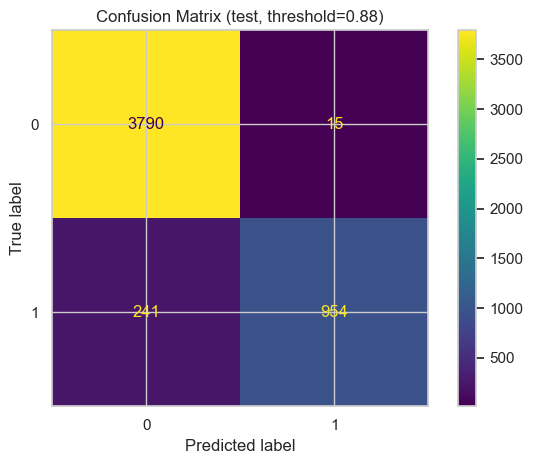

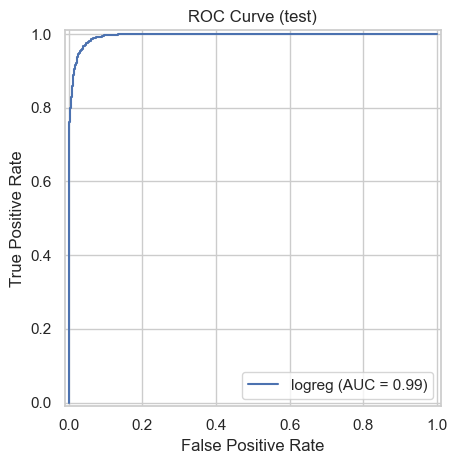

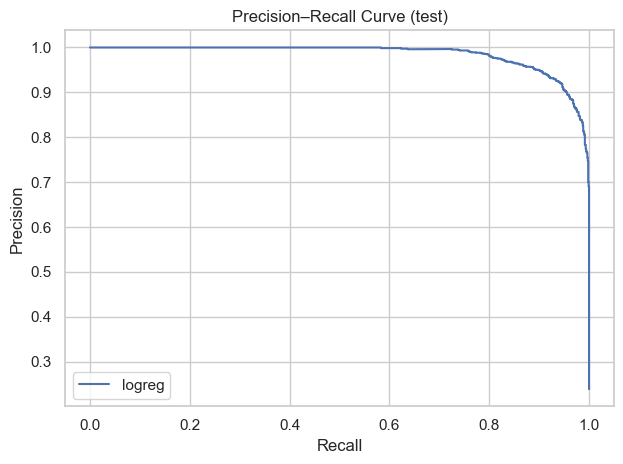

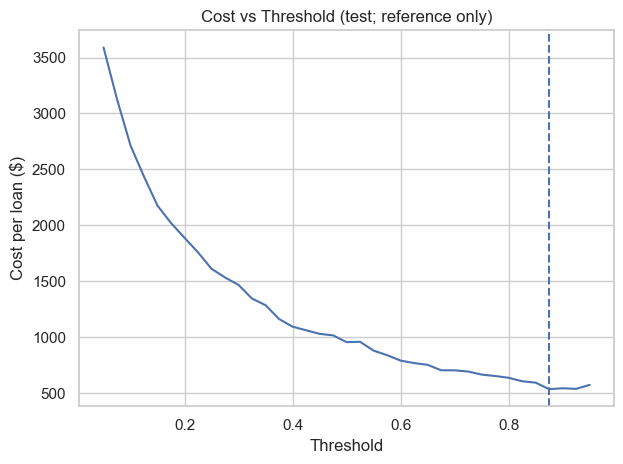


=== Segment analysis: EmploymentStatus (sorted by $/loan) ===
EmploymentStatus      n approval_rate precision   recall       f1      fpr      fnr cost_per_loan
        Employed 4260.0      0.194131  0.989117 0.797271 0.882893 0.002783 0.202729        496.24
      Unemployed  356.0      0.143258  0.960784 0.742424 0.837607 0.006897 0.257576        662.92
   Self-Employed  384.0      0.236979  0.956044 0.844660 0.896907 0.014235 0.155340        854.17

=== Segment analysis: EducationLevel (sorted by $/loan) ===
EducationLevel      n approval_rate precision   recall       f1      fpr      fnr cost_per_loan
       Unknown  248.0      0.000000       N/A      N/A      N/A 0.000000      N/A          0.00
   High School 1362.0      0.116006  0.993671 0.751196 0.855586 0.000867 0.248804        342.14
      Bachelor 1458.0      0.231824  0.982249 0.821782 0.894879 0.005693 0.178218        600.82
     Associate  974.0      0.162218  0.974684 0.740385 0.841530 0.005222 0.259615        648.87
    

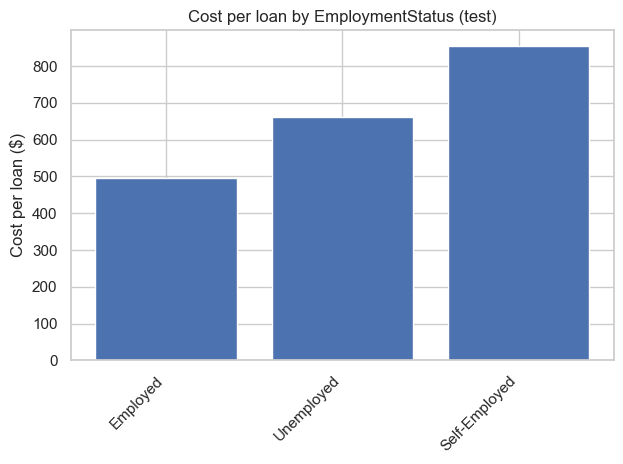

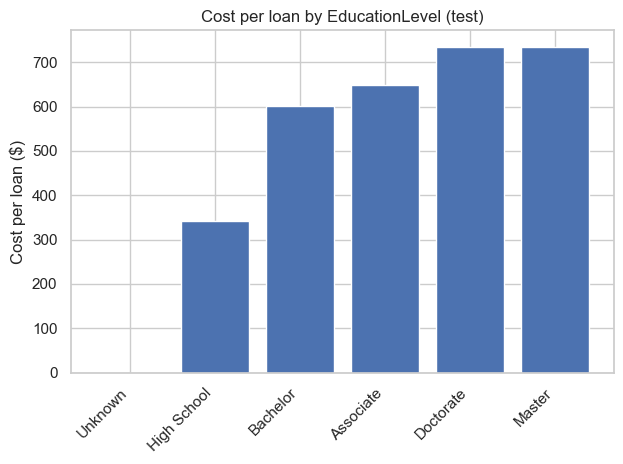


=== Top 15 Feature Importances ===
                    feature  importance
     TotalDebtToIncomeRatio    9.160133
      BankruptcyHistory_Yes    7.218142
               InterestRate    5.797221
              MonthlyIncome    5.179533
   EducationLevel_Doctorate    4.307704
     EducationLevel_Unknown    4.085516
EmploymentStatus_Unemployed    3.326208
                   NetWorth    3.120167
      EducationLevel_Master    2.741964
                 LoanAmount    2.407850
                CreditScore    2.338209
      LengthOfCreditHistory    1.868264
 EducationLevel_High School    1.452419
       PreviousLoanDefaults    1.340703
    EducationLevel_Bachelor    1.334863


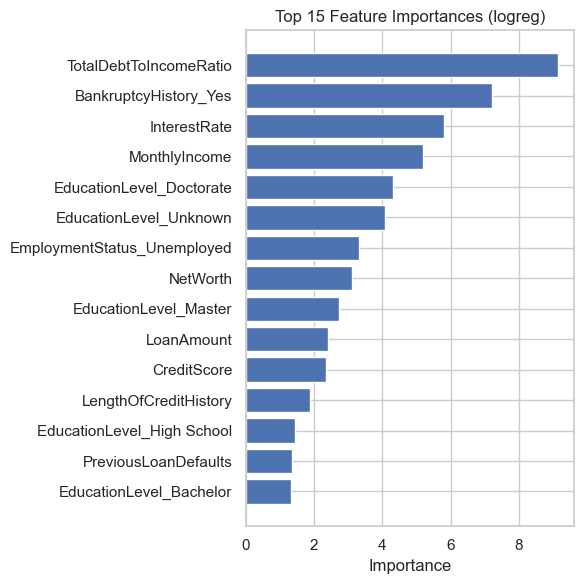

In [84]:
# =============================
# Final Evaluation & Reporting
# =============================

# ---------- 1) Final test metrics ----------
tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat).ravel()
final_cost = (fn*COST_FN + fp*COST_FP) / len(y_test)
metrics_test = {
    "model":      winner_name,
    "threshold":  round(best_t, 2),
    "cost_per_loan": round(final_cost, 2),
    "precision":  precision_score(y_test, y_test_hat, zero_division=0),
    "recall":     recall_score(y_test, y_test_hat,    zero_division=0),
    "f1":         f1_score(y_test, y_test_hat,        zero_division=0),
    "roc_auc":    roc_auc_score(y_test, test_proba),
    "accuracy":   (y_test_hat == y_test).mean(),
    "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
}
print("\n=== Final Test Metrics (locked threshold) ===")
print(pd.Series(metrics_test))

# ---------- 2) Visualizations ----------
# Confusion Matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, ax=ax)
ax.set_title(f"Confusion Matrix (test, threshold={best_t:.2f})")
plt.tight_layout(); plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots()
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name=winner_name).plot(ax=ax)
ax.set_title("ROC Curve (test)")
plt.tight_layout(); plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, test_proba)
fig, ax = plt.subplots()
ax.plot(rec, prec, label=winner_name)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve (test)")
ax.legend()
plt.tight_layout(); plt.show()

# Cost vs Threshold on TEST (diagnostic only — do NOT re-pick the threshold from this)
def cost_curve_on_test(y_true, proba, thresholds=np.linspace(0.05, 0.95, 37)):
    rows = []
    for t in thresholds:
        y_hat = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append({"threshold": t, "cost_per_loan": (fn*COST_FN + fp*COST_FP)/len(y_true)})
    return pd.DataFrame(rows)

test_cost_curve = cost_curve_on_test(y_test, test_proba)
fig, ax = plt.subplots()
ax.plot(test_cost_curve["threshold"], test_cost_curve["cost_per_loan"])
ax.axvline(best_t, linestyle="--")
ax.set_xlabel("Threshold"); ax.set_ylabel("Cost per loan ($)")
ax.set_title("Cost vs Threshold (test; reference only)")
plt.tight_layout(); plt.show()

# ---------- 3) Segment analysis (quiet + future-proof) ----------
eval_df = X_test.copy()
eval_df = eval_df.assign(y_true=y_test.values, y_hat=y_test_hat, proba=test_proba)

def group_metrics(df: pd.DataFrame) -> pd.Series:
    n = len(df)
    if n == 0:
        return pd.Series({
            "n": 0,
            "approval_rate": np.nan,
            "precision": np.nan, "recall": np.nan, "f1": np.nan,
            "fpr": np.nan, "fnr": np.nan,
            "cost_per_loan": np.nan
        })

    y_true = df["y_true"].astype(int)
    y_hat  = df["y_hat"].astype(int)

    # Always return a 2x2, even when the group has only one class
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0, 1]).ravel()

    # Safe metric helpers
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall    = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    f1        = (2 * precision * recall / (precision + recall)
                 if np.isfinite(precision) and np.isfinite(recall) and (precision + recall) > 0 else np.nan)
    fpr       = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr       = fn / (fn + tp) if (fn + tp) > 0 else np.nan

    cost_per_loan = (fp * COST_FP + fn * COST_FN) / n

    return pd.Series({
        "n": n,
        "approval_rate": y_hat.mean(),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fpr": fpr,
        "fnr": fnr,
        "cost_per_loan": cost_per_loan
    })

# choose compact categoricals and a few binned numerics
candidate_cats = [c for c in categorical_cols if c in eval_df.columns and eval_df[c].nunique() <= 12]
cats_to_use = candidate_cats[:5]

num_bins = []
for col in ["AnnualIncome", "LoanAmount", "DebtToIncomeRatio",
            "PaymentToIncome", "NetWorthToLoan", "CreditCardUtilizationRate"]:
    if col in eval_df.columns:
        try:
            eval_df[col + "_bin"] = pd.qcut(eval_df[col], q=5, duplicates="drop")
            num_bins.append(col + "_bin")
        except Exception:
            pass

segment_cols = cats_to_use + num_bins

seg_tables = {}
for col in segment_cols:
    grouped = eval_df.groupby(col, dropna=False, observed=False)
    try:
        tbl = grouped.apply(group_metrics, include_groups=False).reset_index()
    except TypeError:
        tbl = grouped.apply(lambda g: group_metrics(g.drop(columns=[col]))).reset_index()

    # sort by cost numerically (use the numeric table)
    tbl = tbl.sort_values("cost_per_loan").reset_index(drop=True)
    seg_tables[col] = tbl

    # ----- display version with "N/A" instead of NaN on selected metrics -----
    display_cols = ["precision", "recall", "f1", "fpr", "fnr"]
    tbl_disp = tbl.copy()
    for c in display_cols:
        # keep dtype object for pretty printing but don’t lose numeric original (tbl)
        tbl_disp[c] = tbl_disp[c].apply(lambda v: "N/A" if (pd.isna(v) or not np.isfinite(v)) else f"{v:.6f}")

    # approval_rate as percent string (optional nicety)
    tbl_disp["approval_rate"] = tbl["approval_rate"].apply(lambda v: f"{v:.6f}")

    # cost formatting (optional)
    tbl_disp["cost_per_loan"] = tbl["cost_per_loan"].apply(lambda v: f"{v:,.2f}")

    print(f"\n=== Segment analysis: {col} (sorted by $/loan) ===")
    print(tbl_disp.to_string(index=False))

# Optional quick bars for first 2 segments (set ticks before labels to avoid warnings)
for col in segment_cols[:2]:
    tbl = seg_tables[col]
    fig, ax = plt.subplots()
    ax.bar(range(len(tbl)), tbl["cost_per_loan"])
    ax.set_xticks(range(len(tbl)))
    ax.set_xticklabels(tbl[col].astype(str), rotation=45, ha="right")
    ax.set_title(f"Cost per loan by {col} (test)")
    ax.set_ylabel("Cost per loan ($)")
    plt.tight_layout(); plt.show()

# ---------- 4) Feature importance / coefficients ----------
# Handles RF, LogReg, Linear SVM; else falls back to permutation importance
from sklearn.inspection import permutation_importance

final_clf = best_model.named_steps["clf"]

# feature names after preprocessing (handle case with no categoricals)
cat_features = []
try:
    ohe = best_model.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
    cat_features = list(ohe.get_feature_names_out(categorical_cols))
except Exception:
    cat_features = []

all_features = list(numeric_cols) + cat_features

if hasattr(final_clf, "feature_importances_"):            # RandomForest
    importances = final_clf.feature_importances_
elif hasattr(final_clf, "coef_"):                         # LogReg or Linear SVM
    importances = np.abs(final_clf.coef_).ravel()
else:                                                     # fallback: permutation importance on the pipeline
    r = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    importances = r.importances_mean

fi_df = pd.DataFrame({"feature": all_features, "importance": importances}) \
         .sort_values("importance", ascending=False)

print("\n=== Top 15 Feature Importances ===")
print(fi_df.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(6, 6))
ax.barh(fi_df.head(15)["feature"][::-1], fi_df.head(15)["importance"][::-1])
ax.set_title(f"Top 15 Feature Importances ({winner_name})")
ax.set_xlabel("Importance")
plt.tight_layout(); plt.show()

## Conclusion

- **Primary objective:** Minimize expected $ cost per loan using `COST_FP=$50k`, `COST_FN=$8k`.
- **Best model + hyperparams:** As selected via cross-validation in the pipeline; threshold tuned on a held-out validation split. These choices are **frozen** before evaluating on test to avoid leakage.
- **Decision policy:** Use the locked probability threshold from validation for production scoring. Re-tune if the business costs or base rates shift materially.
- **Governance:** Monitor calibration and drift monthly; track segment-level costs (e.g., income bands, DTI) to ensure fairness and stable performance.

### Final Evaluation

**Test Set Metrics (Logistic Regression, C=10, threshold=0.88)**

| Metric            | Value   |
|-------------------|---------|
| Misclassification Cost/Loan | **$535.60** |
| Baseline Cost/Loan (deny-all) | $1,912.00 |
| Improvement       | **$1,376 per loan (72% reduction)** |
| Precision         | 0.985   |
| Recall            | 0.798   |
| F1 Score          | 0.882   |
| ROC AUC           | 0.995   |
| Accuracy          | 0.949   |

---

Our best-performing model, a **Logistic Regression (C=10, threshold tuned to 0.88)**, achieved a **Misclassification Cost per Loan** of approximately **$535.60** when evaluated against officer labels, compared with a naïve deny-all baseline of **$1,912**. This represents an improvement of roughly **$1,376 per loan (a 72% reduction)**. While this does not imply cost savings over historical practice, it shows that cost-sensitive modeling can guide approval policies if applied directly to repayment outcomes in future data.

### Recommendation
- **Deploy** the tuned Logistic Regression model with threshold = 0.88.
- **Monitor** calibration, cost per loan, and fairness across segments monthly.
- **Re-tune** threshold if business costs or class balance shift materially.


In [85]:
# Optional sanity check: ensure feature-name vector matches importances length (run after training)
try:
    n_features_model = None
    if 'final_clf' in globals() and hasattr(final_clf, 'n_features_in_'):
        n_features_model = final_clf.n_features_in_
    if 'all_features' in globals():
        n_features_names = len(all_features)
    else:
        n_features_names = None
    if 'importances' in globals():
        n_importances = len(importances)
    else:
        n_importances = None
    print('Model n_features_in_:', n_features_model)
    print('len(all_features):', n_features_names)
    print('len(importances):', n_importances)
    if n_features_model is not None and n_features_names is not None:
        assert n_features_model == n_features_names, 'Mismatch between model feature count and feature-name list.'
    if n_importances is not None and n_features_names is not None:
        assert n_importances == n_features_names, 'Mismatch between importances and feature-name list.'
    print('Feature alignment checks passed (or not applicable).')
except Exception as e:
    print('Sanity check failed:', e)


Model n_features_in_: 49
len(all_features): 49
len(importances): 49
Feature alignment checks passed (or not applicable).
